# Scientific Authors Collaboration
Link: https://snap.stanford.edu/data/ca-HepTh.html
> This datasets contains a collaboration network that covers scientific collaborations between authors papers submitted to High Energy Physics - Theory category. If an author co-authored a paper with another author, the graph contains a undirected edge between them.

In [17]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import sys
sys.path.append('../')
from utils import negative_sampling as ns, splits

# Const
dataset = "data/CA-HepTh.txt"
random.seed(42)

In [18]:
## Create Graph ##
G = nx.read_edgelist(dataset, nodetype=int)

print("Nodes:",len(list(G.nodes)))
print("Edges:",len(list(G.edges)))

Nodes: 9877
Edges: 25998


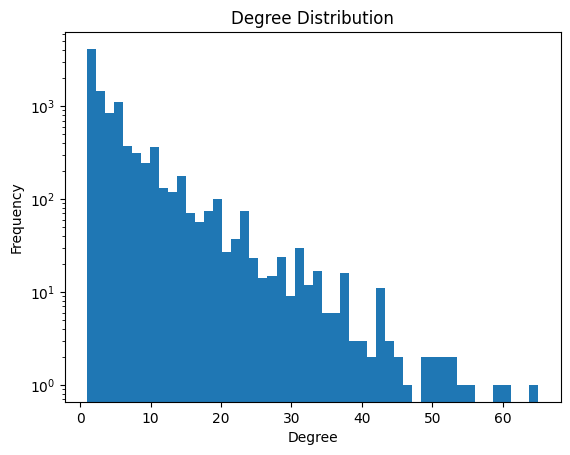

In [19]:
# Degree Distribution Plot
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

In [20]:
# Number of connected components
print("Number of connected components:", nx.number_connected_components(G))
largest_cc = max(nx.connected_components(G), key=len)
print("Size of largest component:", len(largest_cc))

Number of connected components: 429
Size of largest component: 8638


In [21]:
def build_feature_dataset(pairs, G, features=None):
    # Default to all features if none specified
    if features is None:
        features = ['cn', 'jc', 'aa', 'pa', 'ra']

    feature_data = {}

    if 'cn' in features:
        feature_data['cn'] = [len(list(nx.common_neighbors(G, u, v))) for u, v in pairs]

    if 'jc' in features:
        feature_data['jc'] = [coeff for _, _, coeff in nx.jaccard_coefficient(G, pairs)]

    if 'aa' in features:
        aa_scores = []
        for u_node, v_node in pairs:
            try:
                _, _, score = list(nx.adamic_adar_index(G, [(u_node, v_node)]))[0]
                aa_scores.append(score)
            except (ZeroDivisionError, StopIteration):
                aa_scores.append(0.0)
        feature_data['aa'] = aa_scores

    if 'pa' in features:
        feature_data['pa'] = [coeff for _, _, coeff in nx.preferential_attachment(G, pairs)]

    if 'ra' in features:
        feature_data['ra'] = [coeff for _, _, coeff in nx.resource_allocation_index(G, pairs)]

    # Combine feature
    feature_vectors = []
    for i in range(len(pairs)):
        vector = [feature_data[feat][i] for feat in features]
        feature_vectors.append(vector)

    return feature_vectors

In [22]:
feature_combinations = [
    # Single features
    (['cn'], '(cn)'),
    (['jc'], '(jc)'),
    (['aa'], '(aa)'),
    (['pa'], '(pa)'),
    (['ra'], '(ra)'),

    # Progressive combinations
    (['cn', 'jc'], '(cn, jc)'),
    (['cn', 'jc', 'aa'], '(cn, jc, aa)'),
    (['cn', 'jc', 'aa', 'pa'], '(cn, jc, aa, pa)'),
    (['cn', 'jc', 'aa', 'pa', 'ra'], '(cn, jc, aa, pa, ra)'),

    # Additional interesting combinations
    (['cn', 'aa'], '(cn, aa)'),
    (['cn', 'pa'], '(cn, pa)'),
    (['cn', 'ra'], '(cn, ra)'),
    (['jc', 'aa'], '(jc, aa)'),
    (['jc', 'pa'], '(jc, pa)'),
    (['jc', 'ra'], '(jc, ra)'),
    (['aa', 'pa'], '(aa, pa)'),
    (['aa', 'ra'], '(aa, ra)'),
    (['pa', 'ra'], '(pa, ra)'),

    # Three feature combinations
    (['cn', 'jc', 'ra'], '(cn, jc, ra)'),
    (['cn', 'aa', 'ra'], '(cn, aa, ra)'),
    (['jc', 'aa', 'ra'], '(jc, aa, ra)'),
]

def evaluate_pipeline(G, feature_combinations, negative_sampler, strategy_name):
    results = []
    for features, description in feature_combinations:
        X_train, X_test, y_train, y_test = splits.create_train_test_split(
            G,
            lambda pairs, G_train_graph: build_feature_dataset(pairs, G_train_graph, features),
            lambda: negative_sampler(G)
        )

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        auc_pr = average_precision_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_pred)

        results.append({
            'Features': description,
            'AUC_ROC': auc_roc,
            'AUC_PR': auc_pr,
            'Sampling': strategy_name
        })
    return pd.DataFrame(results)

In [23]:
df_common_neighbors = evaluate_pipeline(
    G, feature_combinations, ns.common_neighbors_hard_negative_sampling, "common_neighbors"
)

In [24]:
df_random = evaluate_pipeline(
    G, feature_combinations, ns.random_negative_sampling, "random"
)

In [25]:
df_common_neighbors = df_common_neighbors.rename(columns={
    "AUC_ROC": "AUC_ROC_cn",
    "AUC_PR": "AUC_PR_cn"
}).drop(columns=["Sampling"])

df_random = df_random.rename(columns={
    "AUC_ROC": "AUC_ROC_random",
    "AUC_PR": "AUC_PR_random"
}).drop(columns=["Sampling"])

# Merge side-by-side on the 'Features' column
pd.merge(df_common_neighbors, df_random, on=["Features"])


,Features,AUC_ROC_cn,AUC_PR_cn,AUC_ROC_random,AUC_PR_random
0,(cn),0.662030,0.649857,0.868397,0.868113
1,(jc),0.654498,0.660677,0.865128,0.865185
2,(aa),0.729776,0.728078,0.868605,0.867665
3,(pa),0.507677,0.530259,0.724677,0.761134
4,(ra),0.731166,0.730460,0.862716,0.862400
5,"(cn, jc)",0.661606,0.676046,0.863932,0.863537
6,"(cn, jc, aa)",0.689002,0.703567,0.864806,0.863930
7,"(cn, jc, aa, pa)",0.567077,0.643265,0.840788,0.898952
8,"(cn, jc, aa, pa, ra)",0.585127,0.652787,0.855759,0.908792
9,"(cn, aa)",0.745337,0.747763,0.865563,0.865001


### Results analysis
As expected the scores obtained with the "hard" negative sampling are significantly lower than the ones obtained with the random sampling. These lower scores are likely a much more realistic assessment of how well these specific topological features can perform on this dataset when the task is difficult.

**In this situation (but probably almost always) random negative sampling can be too optimistic.**

Let's see how the individual features scores dropped:
- CN (Random): 0.86 -> (Hard): 0.66 (Drop of 0.20)
- JC (Random): 0.87 -> (Hard): 0.65 (Drop of 0.22)
- AA (Random): 0.86 -> (Hard): 0.73 (Drop of 0.13)
- RA (Random): 0.86 -> (Hard): 0.73 (Drop of 0.13)
- PA (Random): 0.72 -> (Hard): 0.51 (Drop of 0.21)

This demonstrates that with the increasing difficulties of the problem a weighted measure (AA and RA) is more reliable than simpler ones. They penalize common neighbors that have high degree. In the hard negative sampling, many non-links will share common neighbors. AA and RA are better at distinguishing which common neighbors are more indicative of a true link.

With hard negatives, PA performs close to random. This suggests that simply having high-degree nodes involved isn't a good discriminator in this collaboration network.
Can also be noted that PA  combined to other feature gives contrasting results between AUC-ROC and AUC-PR:
- **AUC-ROC**: adding PA to combinations of other features the AUC-ROC score often does not improve significantly and sometimes even sees a decrease. That happens because ROC assign scores based on the ability of the model to separate all positives from all negatives, and since PA boosts scores for all high-degree nodes (including many that aren't true links), it can *mix up the overall rankings*, making it harder to clearly separate true positives from true negatives.
- **AUC-PR**: adding PA to strong feature combinations consistently resulted in a significant boost to the AUC-PR score. That happens because PR focuses on the model's performance on the positive class, especially finding actual positives. While PA might be weak overall, it can find a subset of true positive links involving high-degree nodes, and place these correctly high in the prediction list. This specific discovery of new, high-confidence true positives *significantly boosts the average precision*, leading to a higher AUC-PR.

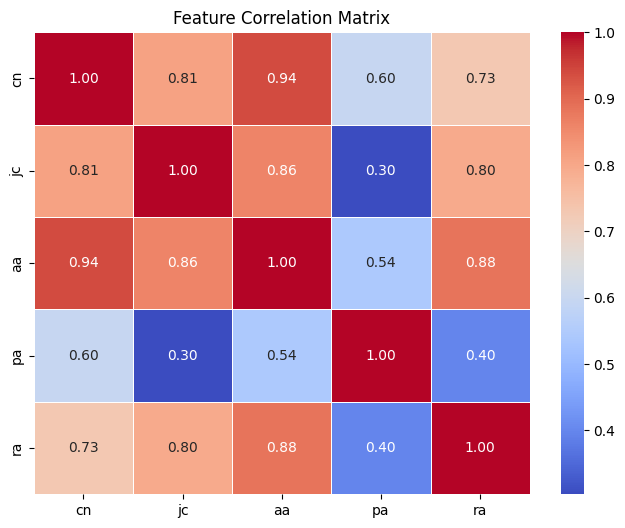

In [26]:
features=['cn', 'jc', 'aa', 'pa', 'ra']
X_train_for_corr, _, _, _ = splits.create_train_test_split(
    G,
    lambda p, G: build_feature_dataset(p, G, features),
    lambda: ns.random_negative_sampling(G)
)

# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(X_train_for_corr, columns=features).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()

Preferential Attachment is anyway the only topology feature that is not correlated with others, making an important factor to always be considered.